# Statistical and Probabilistic Analysis of HDFS System Logs for Anomaly Detection


## 1- Dataset Import

In [4]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats


In [5]:
%pip install kagglehub[pandas-datasets]

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import pandas as pd
import kagglehub

DATASET = "ayenuryrr/loghub-hdfs-hadoop-distributed-file-system-data"

dataset_dir = kagglehub.dataset_download(DATASET)
print("Dataset dir:", dataset_dir)

def load_csv(rel_path: str, **read_kwargs) -> pd.DataFrame:
    path = os.path.join(dataset_dir, rel_path)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    return pd.read_csv(path, **read_kwargs)


Dataset dir: C:\Users\saied\.cache\kagglehub\datasets\ayenuryrr\loghub-hdfs-hadoop-distributed-file-system-data\versions\3


## 2- Data Preprocessing

In [7]:
# SET CONSTANTS
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

RANDOM_STATE = 42

### Load data

In [8]:
labels = load_csv(r"HDFS_v1\preprocessed\anomaly_label.csv")
traces = load_csv(r"HDFS_v1\preprocessed\Event_traces.csv")
occ    = load_csv(r"HDFS_v1\preprocessed\Event_occurrence_matrix.csv")
tpl    = load_csv(r"HDFS_v1\preprocessed\HDFS.log_templates.csv")

print("labels:", labels.shape)
print("traces:", traces.shape)
print("occ   :", occ.shape)
print("tpl   :", tpl.shape)

labels.head()

labels: (575061, 2)
traces: (575061, 6)
occ   : (575061, 32)
tpl   : (29, 2)


,BlockId,Label
0,blk_-1608999687919862906,Normal
1,blk_7503483334202473044,Normal
2,blk_-3544583377289625738,Anomaly
3,blk_-9073992586687739851,Normal
4,blk_7854771516489510256,Normal


### Data Cleaning and Label Encoding

In [9]:
# Standardize column names
labels = labels.rename(columns={labels.columns[0]: "BlockId", labels.columns[1]: "Label"})
occ    = occ.rename(columns={occ.columns[0]: "BlockId"})

# Drop duplicates on BlockId
labels = labels.drop_duplicates(subset=["BlockId"])
occ    = occ.drop_duplicates(subset=["BlockId"])

# 3) Ensure same type for BlockId
labels["BlockId"] = labels["BlockId"].astype(str)
occ["BlockId"]    = occ["BlockId"].astype(str)

# Encode label to y in {0,1}
map_lbl = {"normal": 0, "anomaly": 1}
labels["y"] = labels["Label"].astype(str).str.strip().str.lower().map(map_lbl)
labels["y"] = labels["y"].fillna(pd.to_numeric(labels["Label"], errors="coerce")).astype(int)

print("Label distribution:\n", labels["y"].value_counts())

# Merge dataframes
df = occ.merge(labels[["BlockId", "y"]], on="BlockId", how="inner")
print("Merged shape:", df.shape, " Anomaly rate:", df["y"].mean())

Label distribution:
 0    558223
1     16838
Name: y, dtype: int64
Merged shape: (575061, 33)  Anomaly rate: 0.029280371995318757


In [37]:
# Event columns are all except BlockId and y
event_cols = [c for c in df.columns if c not in ["BlockId", "y"]]

# Force numeric counts, fill NaN with 0, clip negatives
df[event_cols] = df[event_cols].apply(pd.to_numeric, errors="coerce").fillna(0).clip(lower=0)

# Core engineered features
df["total_count"]     = df[event_cols].sum(axis=1)
df["unique_events"]   = (df[event_cols] > 0).sum(axis=1)
df["max_event_count"] = df[event_cols].max(axis=1)
df["log_total"]       = np.log1p(df["total_count"])

core = ["total_count", "unique_events", "max_unique_events", "log_total"]

# Pick top-k event columns by global frequency
k = 15
top_events = df[event_cols].sum(axis=0).sort_values(ascending=False).head(k).index.tolist()
print("Top events:", top_events)

# Final feature table for the project
df_feat = df[["BlockId", "y", "total_count", "unique_events", "max_event_count", "log_total"] + top_events].copy()
df_feat.head()


Top events: ['total_count', 'max_event_count', 'unique_events', 'log_total', 'E5', 'E26', 'E11', 'E9', 'E21', 'E23', 'E22', 'E3', 'E4', 'Type', 'E2']


,BlockId,y,total_count,unique_events,max_event_count,log_total,total_count,max_event_count,unique_events,log_total,E5,E26,E11,E9,E21,E23,E22,E3,E4,Type,E2
0,blk_-1608999687919862906,0,758.598422,16,758.598422,6.632790,758.598422,758.598422,16,6.632790,10,10,3,3,10,10,1,203,0,0.0,0
1,blk_7503483334202473044,0,59.135494,13,59.135494,4.096600,59.135494,59.135494,13,4.096600,3,3,3,3,3,3,1,1,0,0.0,2
2,blk_-3544583377289625738,1,706.501258,14,706.501258,6.561739,706.501258,706.501258,14,6.561739,3,3,3,3,3,3,1,203,0,21.0,0
3,blk_-9073992586687739851,0,58.135494,12,58.135494,4.079831,58.135494,58.135494,12,4.079831,3,3,3,3,3,3,1,0,0,0.0,3
4,blk_7854771516489510256,0,104.663562,14,104.663562,4.660260,104.663562,104.663562,14,4.660260,3,3,3,3,3,3,1,1,15,0.0,3


#### Sanity Check

In [11]:
print("df_feat shape:", df_feat.shape)
print("Any missing:", df_feat.isna().sum().sum())
print(df_feat[["total_count","unique_events","max_event_count","log_total"]].describe().T)


df_feat shape: (575061, 21)
Any missing: 0
                    count       mean       std       min        25%        50%        75%         max
total_count      575061.0  19.708337  5.285621  5.000000  19.000000  19.000000  22.000000  301.000000
unique_events    575061.0   7.276689  1.568829  3.000000   7.000000   7.000000   8.000000   21.000000
max_event_count  575061.0   3.591396  3.116545  3.000000   3.000000   3.000000   3.000000  203.000000
log_total        575061.0   3.002583  0.237592  1.791759   2.995732   2.995732   3.135494    5.710427


## 3-Univariate Analysis

### Summary Table

In [12]:
def univariate_summary(s: pd.Series) -> dict:
    s = pd.to_numeric(s, errors="coerce").dropna()
    q1, q2, q3 = s.quantile([0.25, 0.50, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outlier_rate = ((s < lower) | (s > upper)).mean()

    return {
        "n": int(s.shape[0]),
        "mean": float(s.mean()),
        "std": float(s.std(ddof=1)),
        "min": float(s.min()),
        "q1": float(q1),
        "median": float(q2),
        "q3": float(q3),
        "max": float(s.max()),
        "skew": float(s.skew()),
        "kurtosis": float(s.kurtosis()),
        "outlier_rate_IQR": float(outlier_rate),
    }

features_uni = ["total_count", "unique_events", "max_event_count", "log_total"] + top_events[:6]

summary = pd.DataFrame({col: univariate_summary(df_feat[col]) for col in features_uni}).T
summary


,n,mean,std,min,q1,median,q3,max,skew,kurtosis,outlier_rate_IQR
total_count,575061.0,19.708337,5.285621,5.000000,19.000000,19.000000,22.000000,301.000000,7.367272,299.252169,0.259769
unique_events,575061.0,7.276689,1.568829,3.000000,7.000000,7.000000,8.000000,21.000000,0.354137,0.503210,0.282113
max_event_count,575061.0,3.591396,3.116545,3.000000,3.000000,3.000000,3.000000,203.000000,24.555415,1315.815639,0.131558
log_total,575061.0,3.002583,0.237592,1.791759,2.995732,2.995732,3.135494,5.710427,-0.385957,4.136068,0.255691
E5,575061.0,2.996607,0.220913,1.000000,3.000000,3.000000,3.000000,13.000000,1.410483,143.793185,0.019902
E26,575061.0,2.990537,0.408638,0.000000,3.000000,3.000000,3.000000,13.000000,0.097316,81.840701,0.022045
E11,575061.0,2.967823,0.309920,0.000000,3.000000,3.000000,3.000000,6.000000,-9.422996,87.562005,0.010848
E9,575061.0,2.967536,0.310178,0.000000,3.000000,3.000000,3.000000,3.000000,-9.457102,87.464861,0.010858
E21,575061.0,2.438084,1.184490,0.000000,3.000000,3.000000,3.000000,13.000000,-1.521958,0.573527,0.196859
E23,575061.0,2.427871,1.182648,0.000000,3.000000,3.000000,3.000000,10.000000,-1.549669,0.516168,0.193079


### Normal vs Anomaly Histograms

In [29]:
def compare_hist(df, col, ax, bins=50, logx=False, xmin=None, xmax=None):
    x0 = df.loc[df["y"] == 0, col].dropna()
    x1 = df.loc[df["y"] == 1, col].dropna()

    if logx:
        x0 = np.log1p(x0)
        x1 = np.log1p(x1)

    combined = pd.concat([x0, x1])
    b = np.histogram_bin_edges(combined, bins=bins)

    ax.hist(x0, bins=b, alpha=0.6, label="y=0")
    ax.hist(x1, bins=b, alpha=0.6, label="y=1")
    ax.set_title(f"{col}" + (" (log1p)" if logx else ""))
    ax.set_xlabel(col)
    ax.set_ylabel("count")

    if xmin is not None or xmax is not None:
        lo = xmin if xmin is not None else ax.get_xlim()[0]
        hi = xmax if xmax is not None else ax.get_xlim()[1]
        ax.set_xlim(lo, hi)

def plot_hist_pairs(df, cols, bins=60, logx=False, xlims=None):
    cols = list(cols)
    xlims = xlims or {}

    for i in range(0, len(cols), 2):
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        for j in range(2):
            idx = i + j
            if idx >= len(cols):
                axes[j].axis("off")
                continue

            col = cols[idx]
            xmin, xmax = xlims.get(col, (None, None))
            compare_hist(df, col, axes[j], bins=bins, logx=logx, xmin=xmin, xmax=xmax)
            axes[j].legend()

        fig.suptitle("Histogram comparison (y=0 vs y=1)", y=1.02)
        fig.tight_layout()
        plt.show()



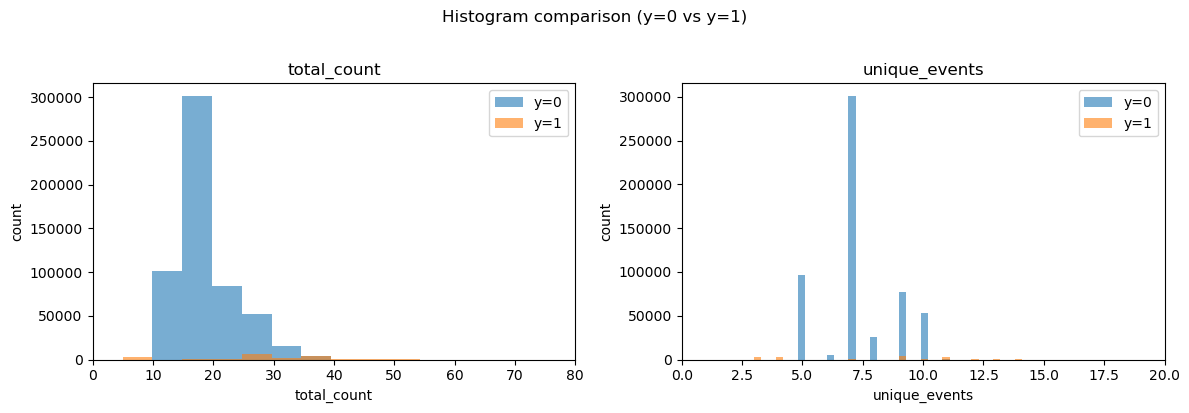

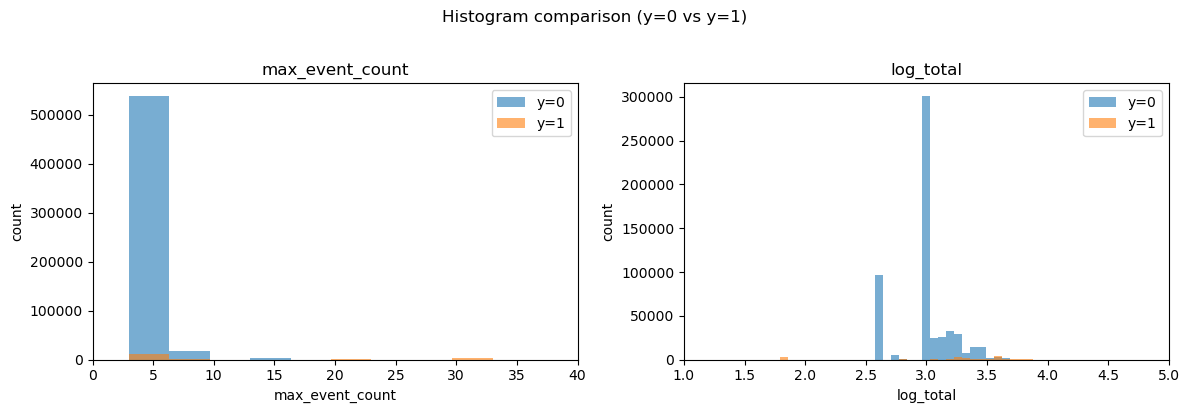

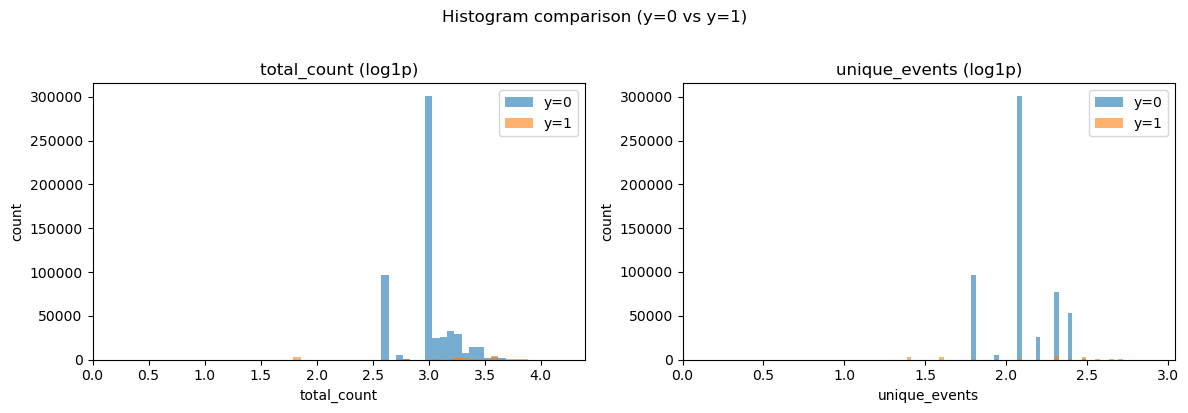

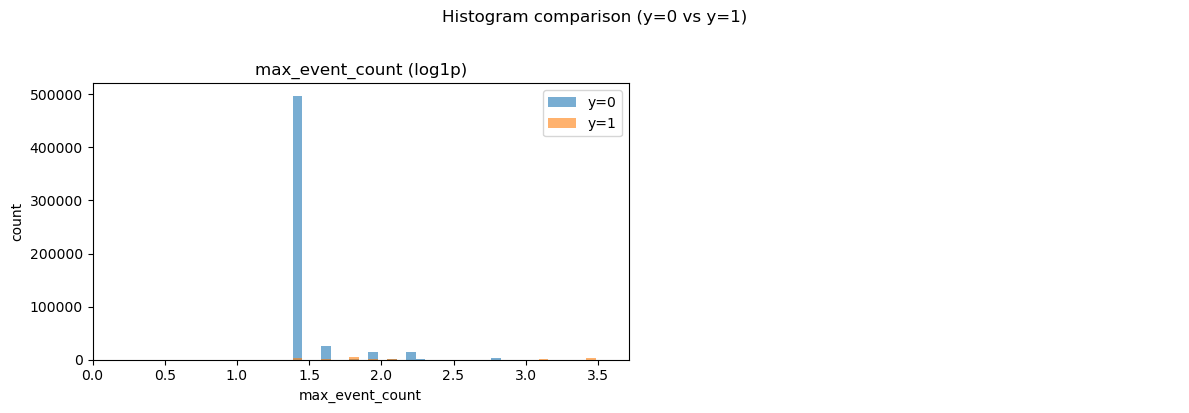

In [30]:
xlims = {
    "total_count": (0, 80),
    "unique_events": (0, 20),
    "max_event_count": (0, 40),
    "log_total": (1,5)
}

plot_hist_pairs(
    df_feat,
    cols=["total_count", "unique_events", "max_event_count", "log_total"],
    bins=60,
    logx=False,
    xlims=xlims
)

# log-scale hist comparisons for these three features
cols_log = ["total_count", "unique_events", "max_event_count"]

xlims_log = {
    "total_count": (0, np.log1p(80)),        
    "unique_events": (0, np.log1p(20)),       
    "max_event_count": (0, np.log1p(40)),     
}

plot_hist_pairs(
    df_feat,
    cols=cols_log,
    bins=60,
    logx=True,
    xlims=xlims_log
)


### Empirical CDF (density) Comparaison

In [32]:
def ecdf(x):
    x = np.sort(np.asarray(x))
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

def plot_ecdf_orig_and_log(df, cols, xlims_orig=None, xlims_log=None):
    xlims_orig = xlims_orig or {}
    xlims_log = xlims_log or {}

    for col in cols:
        x0 = df.loc[df["y"] == 0, col].dropna().values
        x1 = df.loc[df["y"] == 1, col].dropna().values

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Left: original
        xs0, ys0 = ecdf(x0)
        xs1, ys1 = ecdf(x1)
        axes[0].plot(xs0, ys0, label="y=0 normal")
        axes[0].plot(xs1, ys1, label="y=1 anomaly")
        axes[0].set_title(f"ECDF: {col} (original)")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel("ECDF")
        if col in xlims_orig:
            axes[0].set_xlim(*xlims_orig[col])
        axes[0].legend()

        # Right: log1p
        x0_log = np.log1p(x0)
        x1_log = np.log1p(x1)
        xs0l, ys0l = ecdf(x0_log)
        xs1l, ys1l = ecdf(x1_log)
        axes[1].plot(xs0l, ys0l, label="y=0 normal")
        axes[1].plot(xs1l, ys1l, label="y=1 anomaly")
        axes[1].set_title(f"ECDF: log1p({col})")
        axes[1].set_xlabel(f"log1p({col})")
        axes[1].set_ylabel("ECDF")
        if col in xlims_log:
            axes[1].set_xlim(*xlims_log[col])
        axes[1].legend()

        fig.tight_layout()
        plt.show()


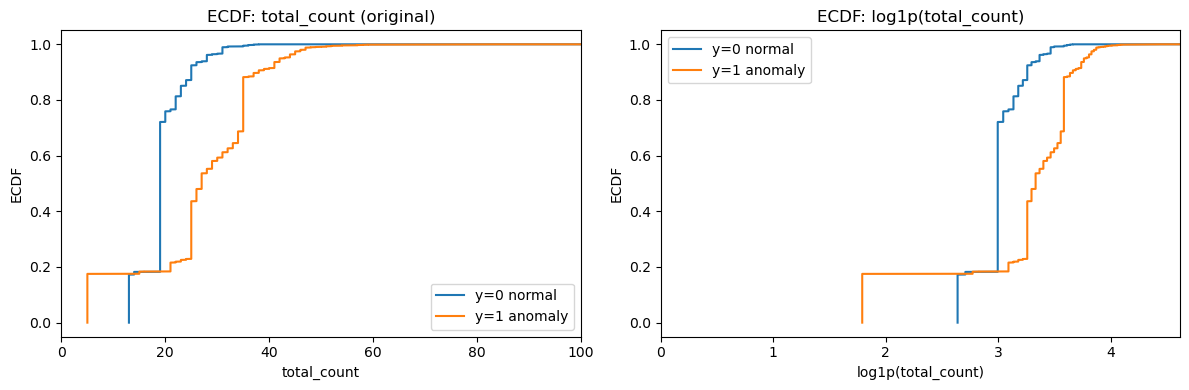

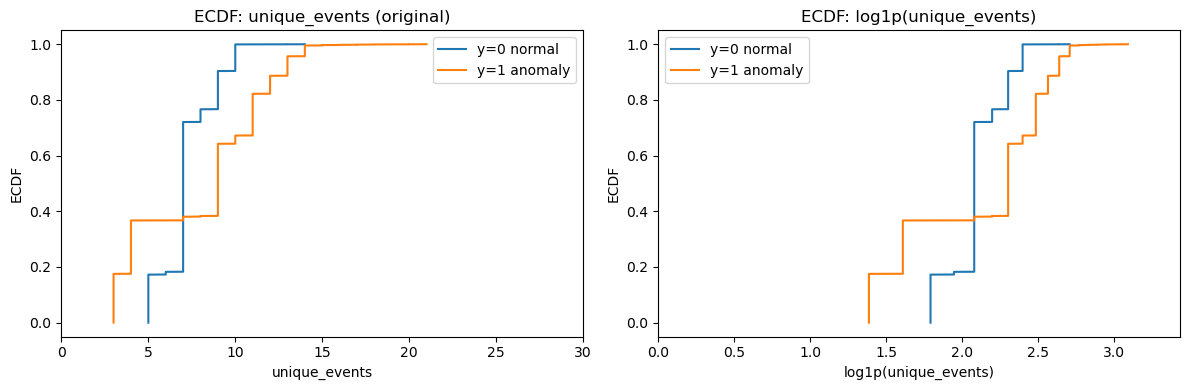

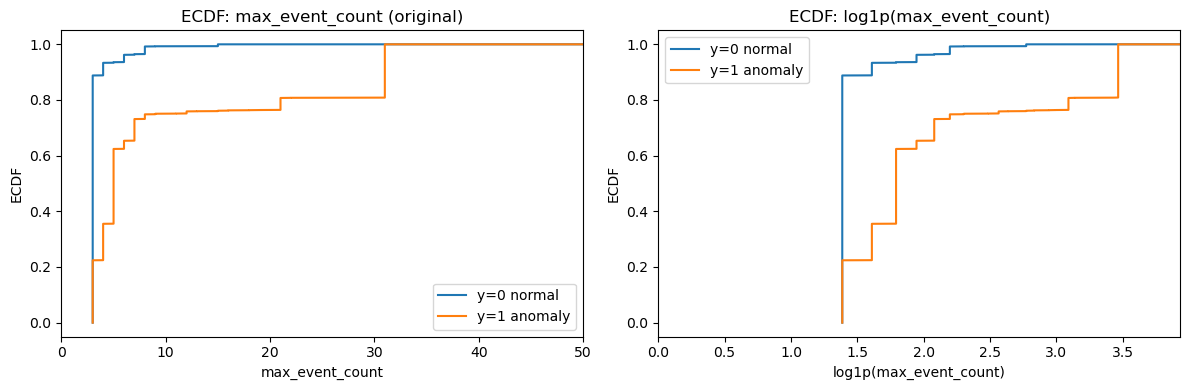

In [35]:
cols = ["total_count", "unique_events", "max_event_count"]

# Optional: cap x ranges (original scale)
xlims_orig = {
    "total_count": (0, 100),
    "unique_events": (0, 30),
    "max_event_count": (0, 50),
}

# Optional: cap x ranges (log scale)
xlims_log = {
    "total_count": (0, np.log1p(100)),
    "unique_events": (0, np.log1p(30)),
    "max_event_count": (0, np.log1p(50)),
}

plot_ecdf_orig_and_log(df_feat, cols, xlims_orig=xlims_orig, xlims_log=xlims_log)


## 3- Multivariate Analysis

### Correlation Matrix

In [38]:
cols_corr = core + top_events
corr = df_feat[cols_corr].corr(numeric_only=True)

plt.figure(figsize=(10, 7))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(cols_corr)), cols_corr, rotation=90)
plt.yticks(range(len(cols_corr)), cols_corr)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()


KeyError: "['max_unique_events'] not in index"